# Toy models of Superposition

This notebook provides an implementation of the toy model featured in the 2022 Anthropic paper [Toy Models of Superposition](https://transformer-circuits.pub/2022/toy_model/index.html). This toymodel is essentially an autoencoder that compresses multiple features into a lower dimensional space (the hidden layer) and then retrieves those features from that layer as accurately as possible. The rules of linear algebra suggest that information must be lost along the way, and that you can only recover as many features as there are neurons in the hidden layer. However, the toymodel demonstrates that when nonlinearities are introduced, and if the data is sparse enough, the model will 'learn' a way to circumvent this obstruction. 

In this short notebook I provide an elementary implementation of this model and the code to plot some of the results of that paper.


## ------ The Model -------

In [ ]:
# import packages
from dataclasses import dataclass
from tqdm import trange
# ... for ML
import torch
from torch.nn import functional as F
# ... and plotting.
import matplotlib.pyplot as plt
import seaborn as sns


@dataclass
class Config:
    n_features: int = 10
    n_hidden: int = 4
    batch_size: int = 30
    importance: float = 1.0     # the importance of the n-th feature = importance ** n
    ReLU_end: bool = False      
    ReLU_hid: bool = False
    sparseness: float = 0.0

class Model():
    def __init__(self, config):
        # store hyperparameters
        self.config = config
        self.importance = config.importance ** torch.arange(config.n_features)
        self.ReLU = (config.ReLU_hid, config.ReLU_end)
        self.sparseness = config.sparseness
        # initialise weights and biases
        self.weights = torch.randn(size=(config.n_features, config.n_hidden), requires_grad=True) 
        self.bias = torch.zeros((1,config.n_features), requires_grad=True)
        self.parameters = [self.bias, self.weights]

    def forward(self, x):
        x = x @ self.weights
        x = F.relu(x) if self.ReLU[0] else x                        # ReLU in hidden layer is only considered in section 7  
        x = x @ torch.transpose(self.weights, 0, 1) + self.bias
        x = F.relu(x) if self.ReLU[1] else x                        # ReLU at the end makes the model 'nonlinear'
        return x
    
    def generate_batch(self):
        batch = torch.rand((self.config.batch_size, self.config.n_features))
        mask = torch.rand(batch.shape) < self.sparseness
        batch[mask] = 0
        return batch

    def train(self, lr=0.1, n_steps=10**5):
        # correct lr for the percentage of zero vectors in the batch whose loss is always zero
        learning_rate =  lr / (1 - self.sparseness ** self.config.n_features)
        loss_hist = []

        for i in trange(n_steps):  

            x = self.generate_batch()
            y = self.forward(x)
            loss = torch.mean((x-y)**2 * self.importance)

            for p in self.parameters:
                p.grad = None
            loss.backward()

            for p in self.parameters:
                p.data += -learning_rate * p.grad 

            if i % 100 == 0:
                loss_hist.append(loss.log10().item())
        
        # store training loss history
        self.loss_hist = loss_hist


In [102]:
def plot_log10loss(model, ax):
    """ Inspect the training loss (log10)"""
    ax.plot(model.loss_hist)        
    
def plot_heatmaps1(model):
    """" Plot heatmaps for the weights 'squared' (W * W^T) and biases"""
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (6, 3))
    
    # get weights and biases
    wwt = model.weights @ torch.transpose(model.weights, 0, 1)
    wwt = wwt.detach().numpy()
    bias = model.bias.detach().numpy().T
    
    # heatmap for weights
    sns.heatmap(wwt,  cmap='RdBu', vmin=-1, vmax=1, ax=ax1, linewidths=0.2, cbar=False, square=True)
    ax1.set_xticks([])
    ax1.set_yticks([])
    # heatmap for biases
    sns.heatmap(bias,  cmap='RdBu', vmin=-1, vmax=1, ax=ax2, linewidths=0.2, cbar=True, square=True)
    ax2.set_xticks([])
    ax2.set_yticks([])

    plt.subplots_adjust(left=0.0, right=2)
    plt.tight_layout()


def plot_heatmaps2(model):
    """ Plot heatmaps for the weights W """
    fig, ax = plt.subplots()
    
    # get weights and biases
    W = model.weights.detach().numpy()

    # heatmap for weights
    sns.heatmap(W,  cmap='RdBu', vmin=-1, vmax=1, ax=ax, linewidths=0.2, cbar=True, square=True)
    ax.set_xticks([])
    ax.set_yticks([])


## ------ Section 2: Demonstrating Superposition ------
In section 2 the nonlinear activition function at the output layer of the model are t



In [ ]:
# We run over four models that differ in:
ReLU_end = [False, True, True, True, True]
sparseness = [0, 0, 0.7, 0.9, 0.98]

# Create list of models and train them for each config
models=[]
for i in range(len(sparseness)):
    config = Config(
        n_features=10,
        n_hidden=4,
        batch_size=30,
        importance= 0.7,
        ReLU_end=ReLU_end[i],
        sparseness=sparseness[i],
    )
    models.append(Model(config=config))
    models[-1].train(lr=0.3, n_steps=10**5)



100%|██████████| 100000/100000 [00:08<00:00, 11298.44it/s]


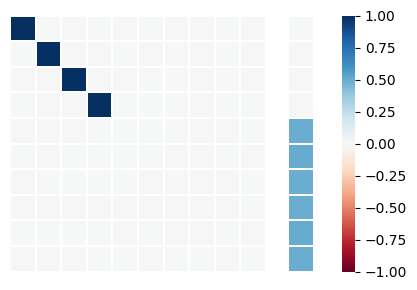

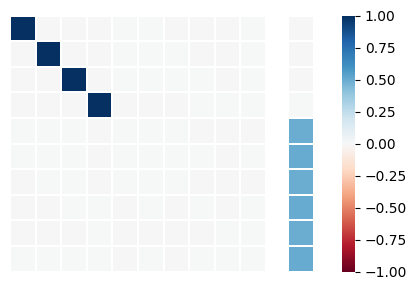

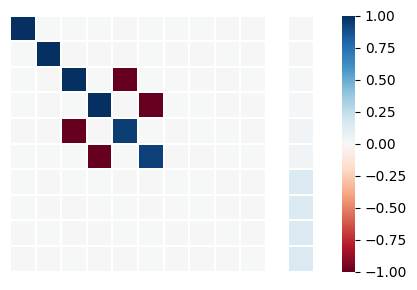

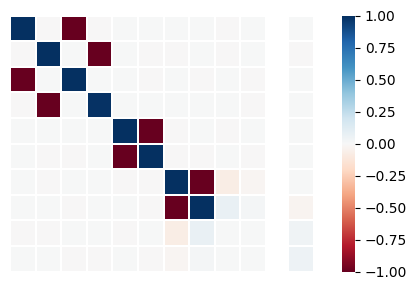

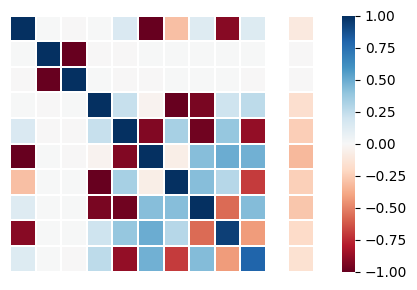

In [122]:
# display the heatmaps of weights and biases
for model in models:
    plot_heatmaps1(model)

## ------ Section 7: Superposition in a Privileged Basis ------

Section 7 discusses the same toymodel, but now  with a ReLU added to the hidden layer. As a consequence, while learning, the model tries to align the most important features with the neurons in the hidden layer. This we can see by plotting the weights themselves (rather than $W * W^T$). As mentioned in the paper, these models are hard to optimize (they pick the best out of a 1000 models) so for convenience, we consider a smaller model (6x3 rather than 10x5) such that we can achieve the same results with limited computing power (sweep over 10 rather than a 1000 models).

In [103]:
def find_best_model(config, n_iterations = 5, lr = 0.3, n_steps=10**5):
    """ For a given set of hyperparameters, find the best model. """
    best_score = float('inf')
    for _ in range(n_iterations):
        model = Model(config=config)
        model.train(lr=lr, n_steps=n_steps)
        score = sum(model.loss_hist[-10:])/10
        if score < best_score:
            best_model = model
            best_score = score
            
        
    print(best_score)
    return best_model         

100%|██████████| 30000/30000 [00:02<00:00, 10378.51it/s]

-1.8811169028282166


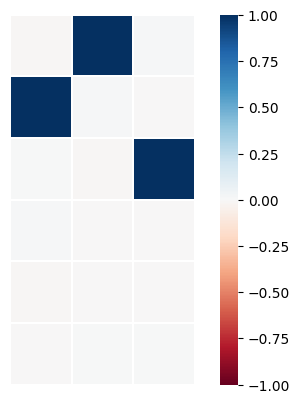

In [ ]:
# Consider a model with ReLU at the hidden layer and end and set sparseness to 0.00
config = Config(
        n_features=6,
        n_hidden=3,
        batch_size=30,
        importance= 0.75,
        ReLU_hid=True,
        ReLU_end=True,
        sparseness=0,
    )

model_00 = find_best_model(config, n_iterations=10, n_steps = 3*10**4)
plot_heatmaps2(model_00)

100%|██████████| 30000/30000 [00:02<00:00, 10807.77it/s]


-2.0748866200447083


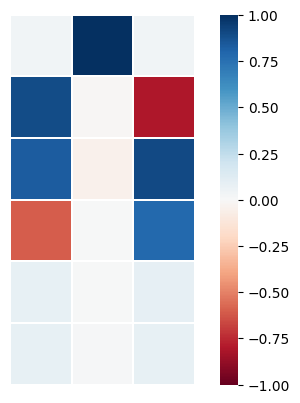

In [ ]:
# Consider a model with ReLU at the hidden layer and end and set sparseness to 0.70
config = Config(
        n_features=6,
        n_hidden=3,
        batch_size=30,
        importance= 0.7,
        ReLU_hid=True,
        ReLU_end=True,
        sparseness=0.7,
    )

model_70 = find_best_model(config, n_iterations=10, n_steps = 3*10**4)
plot_heatmaps2(model_70)

100%|██████████| 50000/50000 [00:04<00:00, 10807.36it/s]


-2.6350049018859862


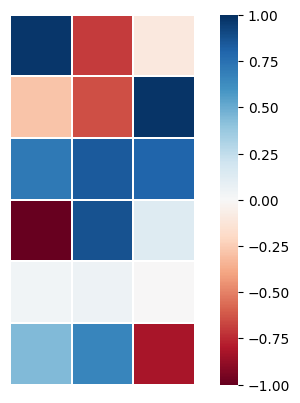

In [ ]:
# Consider a model with ReLU at the hidden layer and end and set sparseness to 0.90
config = Config(
        n_features=6,
        n_hidden=3,
        batch_size=30,
        importance= 0.7,
        ReLU_hid=True,
        ReLU_end=True,
        sparseness=0.90,
    )

model_90 = find_best_model(config, n_iterations=10, n_steps = 5*10**4)
plot_heatmaps2(model_90)

In [ ]:
# Residual code for stack plots

# import numpy as np

# def stack_plot(model, ax):
#     n_features = model.config.n_features
#     W = model.weights.detach().numpy() 
#     WWT = W @ W.T    # 10 x 4
#     c = np.sum(WWT**2, axis=1) - WWT.diagonal()**2
#     bottom = 0

#     x = [str(i) for i in range(model.config.n_hidden)]

#     for i in range(n_features):
#         # color = 'indigo' if c[i] > 0.9 else 'yellow'
#         color = plt.cm.viridis(np.digitize(i, bins=np.linspace(0, n_features, n_features)) / n_features)

#         ax.bar(x, np.abs(W[i]), bottom=bottom, color=color)
#         bottom += np.abs(W[i])+0.02
    

#     print(c.round(2))

# # plot
# fig, ax = plt.subplots(ncols=len(models))
# for i, model in enumerate(models):
#     stack_plot(model, ax[i])

